## This notebook is about learning a Linear Regression model.

### Algorithms from sk-learn
Before writing up our own algorithms, it made sense to use the pre-existing algorithms from libraries such as sklearn.
This provides us a baseline for the performance of LR on our dataset.

### Preliminary Considerations
There were many considerations to be made. The first regarding hyper-parameters and high-dimensional data.
It was important to not overthink the first few steps so considerations with bias-variance and tweaking
were considered later.


In [1]:
import pandas as pd

In [2]:
# Open Dataset
data = pd.read_csv('dataset/GSMArena_dataset_2020.csv', index_col=0)

# Some Insight
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10679 entries, 1 to 10679
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   oem                         10679 non-null  object
 1   model                       10679 non-null  object
 2   network_technology          10679 non-null  object
 3   network_2g_bands            10355 non-null  object
 4   network_gprs                9714 non-null   object
 5   network_edge                9720 non-null   object
 6   launch_announced            10679 non-null  object
 7   launch_status               10679 non-null  object
 8   body_dimensions             10679 non-null  object
 9   body_weight                 10587 non-null  object
 10  body_sim                    10678 non-null  object
 11  display_type                10679 non-null  object
 12  display_size                9287 non-null   object
 13  display_resolution          10630 non-null  ob

,oem,model,network_technology,network_2g_bands,network_gprs,network_edge,launch_announced,launch_status,body_dimensions,body_weight,...,main_camera_dual_or_triple,battery_music_play,selfie_camera_triple,main_camera_v1,selfie_camera,camera,main_camera,network,battery_talk_time,battery_stand.by
key_index,,,,,,,,,,,,,,,,,,,,,
1,Benefon,Vega,GSM,GSM 900,No,No,1999,Discontinued,145 x 56 x 23 mm (5.71 x 2.20 x 0.91 in),190 g (6.70 oz),...,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,4 - 10 h,3 - 6 days
2,Garmin-Asus,nuvifone M10,GSM / HSPA,GSM 900 / 1800 / 1900,NaN,NaN,"2010, January. Released 2010, March",Discontinued,-,-,...,NaN,NaN,NaN,NaN,V2,NaN,NaN,GSM 850 / 1800 / 1900 - US version,Up to 8 h,Up to 600 h (2G) / Up to 600 h (3G)
3,Gigabyte,GSmart G1305 Boston,GSM / HSPA,GSM 850 / 900 / 1800 / 1900,NaN,NaN,"2010, April. Released 2010, April",Discontinued,116 x 56.8 x 12.4 mm (4.57 x 2.24 x 0.49 in),118 g (4.16 oz),...,NaN,NaN,NaN,NaN,V2,NaN,NaN,NaN,Up to 7 h 10 min,Up to 410 h
4,Gigabyte,GSmart,GSM / HSPA,GSM 900 / 1800,NaN,NaN,Not officially announced yet,Cancelled,103 x 54 x 13.4 mm (4.06 x 2.13 x 0.53 in),-,...,NaN,NaN,NaN,NaN,V2,NaN,NaN,NaN,NaN,NaN
5,Google,Pixel 4 XL,GSM / CDMA / HSPA / EVDO / LTE,GSM 850 / 900 / 1800 / 1900,NaN,NaN,"2019, October 15","Available. Released 2019, October 22",160.4 x 75.1 x 8.2 mm (6.31 x 2.96 x 0.32 in),193 g (6.81 oz),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CDMA 800 / 1900,NaN,NaN


### Issues so far
Before attempting to learn a regression model on the data, it is clear that there are some considerations to
be made.

Firstly, some rows have null values (N/A) and some features have categorical values.
Here, we have decided to drop the categorical features, and subsequently drop all the null valued rows.


In [3]:
# Load up data_cleaning script
# noinspection PyUnresolvedReferences
from auxiliary.data_clean2 import clean_data

# Remove features that don't seem necessary at this stage, i.e. take all the other features.
# NOTE: getting rid of 'main_camera_dual', 'comms_nfc', 'battery_charging', 'selfie_camera_video' as they seem to be conflicting/resulting in many null cols.
data_features = data[["oem", "launch_announced", "launch_status", "body_dimensions", "display_size", "comms_wlan", "comms_usb",
                "features_sensors", "platform_os", "platform_cpu", "platform_gpu", "memory_internal",
                "main_camera_single", "main_camera_video", "misc_price",
                "selfie_camera_video",
                "selfie_camera_single", "battery"]]

# Clean up the data into a trainable form.
df = clean_data(data_features)

key_index
1        None
2        None
3        46.3
4        43.7
5        81.3
         ... 
10675    36.1
10676    26.1
10677    26.1
10678    26.1
10679    None
Name: scn_bdy_ratio, Length: 10679, dtype: object key_index
1        None
2         3.5
3         3.2
4         2.8
5         6.3
         ... 
10675     2.4
10676     2.0
10677     2.0
10678     2.0
10679    None
Name: screen_size, Length: 10679, dtype: object
RangeIndex(start=0, stop=779, step=1)


### Preliminary plots

Consider the correlation between certain features (numerical & categorical) and the classes.

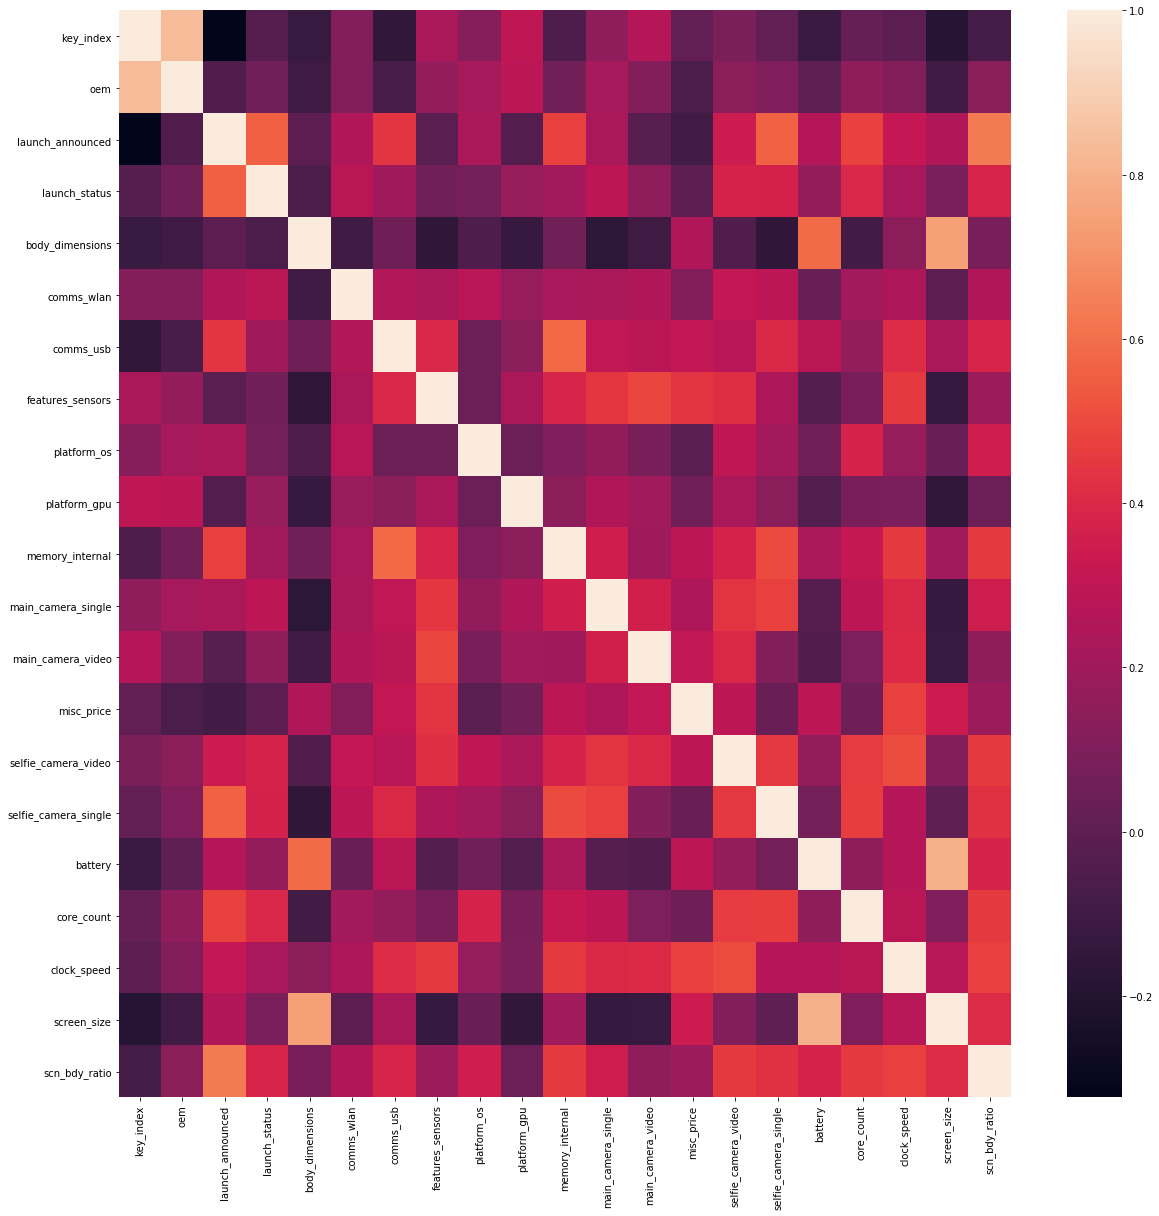

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation & heat map; For visuals & feature selection/validation

# NOTE: OEM was used as the index;

df.dropna(inplace=True)
df.reset_index(drop=True)

plt.figure(figsize=(20,20))
sns.heatmap(df.corr())

### Now that the data is the right format, it is now possible to train a simple LR model.

We start off by investigating the performance of sk-learn's batch-learned LR models.

We then manually drop features that seem, less expressive by the feature_selection script & test the data.

In [5]:
# Now its time to split the data
from sklearn.model_selection import train_test_split

y = df["misc_price"]
X = df.drop(["key_index", "misc_price"], axis=1)
X = X.drop(['launch_status', 'comms_wlan', 'comms_usb', 'platform_os', 'core_count'], axis=1)

# Train & test split. Seed = 120 for reproducing same shuffling of indices.
# Note 70-30 split for the preliminary split.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=120, test_size=.3)

Coefficients: 
 [-7.6386023e-01 -2.7821987e+01 -2.3227913e-04  3.3735561e+01
  1.5468434e+00  5.0533640e-01  5.2145076e+00 -1.7815178e-04
  5.9143942e-02 -1.3373544e+00 -8.6718309e-04  8.1662059e-02
  5.3192139e+01 -1.4882683e+00]
Mean squared error: 16418.48
Coefficient of determination: 0.42


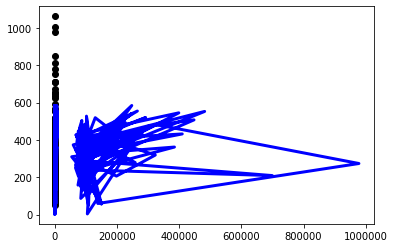

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr_model = LinearRegression()

# Batch-train LR
lr_model.fit(X_train, y_train)

# Test the model & retreive predictions
y_pred = lr_model.predict(X_test)

# The coefficients
print('Coefficients: \n', lr_model.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

plt.scatter(y_pred, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks()
plt.yticks()

plt.show()

### Performance of simple LR
As can be seen, the preliminary performance is very poor. This raises some considerations with whether the data is too noisy or in the wrong form. It could also mean the function is significantly non-linear and our LR model would be a bad choice.

### Plot of data & LR model
We now try to visualize high-dimensional data & try specific combination-correlations, to gain some idea of the nature of the fit.

In [7]:
# plt

# sns


### Investigating Linear Regression in more detail
Now we investigate LR in more depth by learning our own models and tweaking parameters, normalizing and comparing differences.

In [8]:
# Set up the function defs & ML algorithms


In [9]:
# Train our custom LR model


# Test variance -> validation set accuracy


# Perform 4-fold cross-validation on the datasets


# Compile results into table

### Plots & Analysis

So far, our LR model has been trained and tested via cross-validation. We now visualize the scores and analyze the
performance below.

In [10]:
# matplotlib


# sns
